## NOTE: this notebook is for demonstration only and not really part of the workshop

In [1]:
pip install --quiet --upgrade torch torchvision pytorch-lightning wandb matplotlib pillow testresources

Note: you may need to restart the kernel to use updated packages.


## 3 - forest-vs-houses - additions

### 3.1 - feature engineering to improve model

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

on cocalc the data is in ``/data``

data sources (to use at home):
- train/test: https://paste.madflex.de/YtmeRXrY#houses-vs-forest.zip (500mb)
- test2: https://paste.madflex.de/pyHrvXyG#test2_f-vs-h.zip (100mb)
- test3: https://paste.madflex.de/La6ZMHvf#test3_f-vs-h.zip (90mb)

In [3]:
DATA_DIR = "/data/houses-vs-forest"

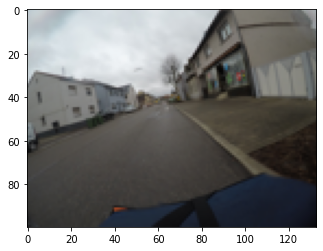

In [4]:
img = Image.open(f"{DATA_DIR}/test3/houses/G0109966.JPG")
plt.imshow(img.resize((133, 100)))
plt.show()

hypothesis: cut the bag on the bottom from the images to improve recognition for test3

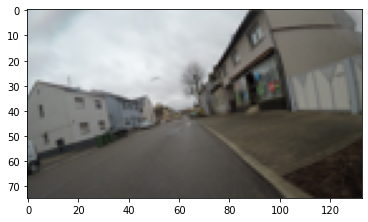

In [5]:
plt.imshow(img.resize((133, 100)).crop((0, 0, 133, 75)))
plt.show()

In [6]:
import torch
import torchvision

In [7]:
import pytorch_lightning as lightning
lightning.seed_everything(42)

Global seed set to 42


42

In [8]:
class CustomCropTransform:
    def __call__(self, img):
        return torchvision.transforms.functional.crop(img, top=0, left=0, height=75, width=133)

In [9]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(100),
    CustomCropTransform(),
    torchvision.transforms.ToTensor()
])

In [10]:
image_train = torchvision.datasets.ImageFolder(f"{DATA_DIR}/train", transform=transforms)

In [11]:
image_count = 107

In [12]:
train_ds, validation_ds = torch.utils.data.random_split(image_train,[(image_count-15)*2, 15*2])

In [13]:
# images from the same tour/day
test_ds = torchvision.datasets.ImageFolder(f"{DATA_DIR}/test", transform=transforms)

In [14]:
# images from *another* tour/day
test2_ds = torchvision.datasets.ImageFolder(f"{DATA_DIR}/test2", transform=transforms)

In [15]:
# images from another tour/day and another bike
test3_ds = torchvision.datasets.ImageFolder(f"{DATA_DIR}/test3", transform=transforms)

In [16]:
all_test_ds = test_ds + test2_ds + test3_ds

bag at the bottom is removed:

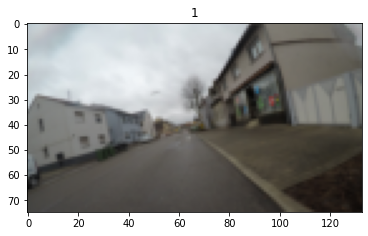

In [17]:
number = 107
plt.imshow(all_test_ds[number][0].permute(1, 2, 0))
plt.title('%i' % all_test_ds[number][1])
plt.show()

now train a new model

In [18]:
import wandb
wandb.login()

wandb: Currently logged in as: mfa (use `wandb login --relogin` to force relogin)


True

In [19]:
from torchmetrics import Accuracy

In [20]:
class ForestHousesCategoricalModel(lightning.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.batch_size = 16

        channels, width, height = train_ds[0][0].size()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.5),
            torch.nn.Flatten(),
            #  75x + channels=20, maxpool=4 -> 11520
            #  75x + channels=20, maxpool=2 -> 46800
            torch.nn.Linear(46800, 2),
        )
        self.loss = torch.nn.CrossEntropyLoss()

        acc = Accuracy()
        self.train_acc = acc.clone()
        self.valid_acc = acc.clone()

    def forward(self, x):
        return self.model(x)

    def step(self, batch, batch_idx, name):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log(f"{name}/loss", loss)

        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        
        if name == "train":
            self.train_acc(preds, y)
            self.log(f"{name}/acc", self.train_acc)
        else:
            self.valid_acc(preds, y)
            self.log(f"{name}/acc", self.valid_acc)

        return {"loss": loss}
    
    def training_step(self, batch, batch_nb):
        return self.step(batch, batch_nb, name="train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="val")
    
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(train_ds, batch_size=self.batch_size)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(validation_ds, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(all_test_ds, batch_size=self.batch_size)

In [21]:
model = ForestHousesCategoricalModel()
model

ForestHousesCategoricalModel(
  (model): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=46800, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
  (train_acc): Accuracy()
  (valid_acc): Accuracy()
)

In [22]:
wandb_logger = lightning.loggers.WandbLogger(project="workshop-p2--FvsH--crop")
wandb_logger.watch(model, log="all")
trainer_categorical = lightning.Trainer(gpus=0, max_epochs=10, logger=wandb_logger)
trainer_categorical.fit(model)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 94.2 K
1 | loss      | CrossEntropyLoss | 0     
2 | train_acc | Accuracy         | 0     
3 | valid_acc | Accuracy         | 0     
-----------------------------------------------
94.2 K    Trainable params
0         Non-trainable params
94.2 K    Total params
0.377     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [23]:
trainer_categorical.test(ckpt_path='best')

Restoring states from the checkpoint path at /home/mfa/machine-learning-workshop/part2/workshop-p2--FvsH--crop/31d0w88r/checkpoints/epoch=9-step=119.ckpt
Loaded model weights from checkpoint at /home/mfa/machine-learning-workshop/part2/workshop-p2--FvsH--crop/31d0w88r/checkpoints/epoch=9-step=119.ckpt
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.7129629850387573, 'test/loss': 1.272516131401062}
--------------------------------------------------------------------------------


[{'test/loss': 1.272516131401062, 'test/acc': 0.7129629850387573}]

In [24]:
wandb.finish()

epoch,▁▂▂▃▄▄▅▅▆▇▇▇█
test/acc,▁
test/loss,▁
train/acc,▁▁
train/loss,█▁
trainer/global_step,▁▂▃▃▃▄▅▆▆▇▇██
val/acc,▁▆▇▇▇█████
val/loss,█▄▃▂▂▁▂▁▁▁
epoch,10
test/acc,0.71296
test/loss,1.27252


In [25]:
import termcolor

In [26]:
def test_result(idx, image, model):
    img = image[0][None, :]
    r = model(img)
    is_correct = bool(image[1] == torch.argmax(r))
    is_correct = termcolor.colored(is_correct, "green" if is_correct else "red")
    return " ".join([str(i) for i in [idx, image[1], test_ds.classes[image[1]], is_correct, torch.argmax(r), r]])

In [27]:
for idx, item in enumerate(all_test_ds):
    print(test_result(idx, item, trainer_categorical.model))

0 0 forest True tensor(0) tensor([[ 0.2106, -0.1054]], grad_fn=<AddmmBackward0>)
1 0 forest True tensor(0) tensor([[ 2.0530, -1.9594]], grad_fn=<AddmmBackward0>)
2 0 forest True tensor(0) tensor([[ 2.0963, -2.0449]], grad_fn=<AddmmBackward0>)
3 0 forest True tensor(0) tensor([[ 1.7820, -1.7834]], grad_fn=<AddmmBackward0>)
4 0 forest True tensor(0) tensor([[ 2.9644, -2.8847]], grad_fn=<AddmmBackward0>)
5 0 forest True tensor(0) tensor([[ 1.9102, -1.6825]], grad_fn=<AddmmBackward0>)
6 0 forest True tensor(0) tensor([[ 4.0752, -3.7904]], grad_fn=<AddmmBackward0>)
7 0 forest True tensor(0) tensor([[ 2.0483, -2.0108]], grad_fn=<AddmmBackward0>)
8 0 forest True tensor(0) tensor([[ 3.2519, -3.1852]], grad_fn=<AddmmBackward0>)
9 0 forest True tensor(0) tensor([[ 3.2641, -3.1894]], grad_fn=<AddmmBackward0>)
10 1 houses True tensor(1) tensor([[-1.5606,  1.6486]], grad_fn=<AddmmBackward0>)
11 1 houses True tensor(1) tensor([[-2.3627,  2.3633]], grad_fn=<AddmmBackward0>)
12 1 houses True tensor(1)

conclusion: worse results than before. maybe different hyperparameters needed?

### 3.2 retrain with more images
(use 2x5 images from each of the two new tours)

link to data for use at home -- data is already there on cocalc!

https://paste.madflex.de/kRYJAwYw#forest-vs-houses--train--additional.zip (the zip contains only the new images!)

In [28]:
DATA_DIR="/data/houses-vs-forest--plus-additional"

In [29]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(100),
    torchvision.transforms.ToTensor()
])

In [30]:
image_train_add = torchvision.datasets.ImageFolder(f"{DATA_DIR}/train", transform=transforms)

In [31]:
image_count = 107 + 5 + 5

In [32]:
train_ds, validation_ds = torch.utils.data.random_split(image_train_add,[(image_count-15)*2, 15*2])

In [33]:
(len(train_ds) / 2) == image_count - 15

True

the transformation changed, so reload the test data too:

In [34]:
# images from the same tour/day
test_ds = torchvision.datasets.ImageFolder(f"{DATA_DIR}/test", transform=transforms)
# images from *another* tour/day
test2_ds = torchvision.datasets.ImageFolder(f"{DATA_DIR}/test2", transform=transforms)
# images from another tour/day and another bike
test3_ds = torchvision.datasets.ImageFolder(f"{DATA_DIR}/test3", transform=transforms)

In [35]:
all_test_ds = test_ds + test2_ds + test3_ds

In [36]:
class ForestHousesCategoricalModel(lightning.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.batch_size = 16

        channels, width, height = train_ds[0][0].size()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.5),
            torch.nn.Flatten(),
            #  100x + channels=20, maxpool=2 -> 63700
            #  100x + channels=50, maxpool=2 -> 159250
            #  100x + channels=50, maxpool=4 -> 38400
            #  100x + channels=20, maxpool=4 -> 15360
            #  channels=50, maxpool=2, kernel=5 -> 153600
            torch.nn.Linear(63700, 2),
        )
        self.loss = torch.nn.CrossEntropyLoss()

        acc = Accuracy()
        self.train_acc = acc.clone()
        self.valid_acc = acc.clone()

    def forward(self, x):
        return self.model(x)

    def step(self, batch, batch_idx, name):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log(f"{name}/loss", loss)

        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        
        if name == "train":
            self.train_acc(preds, y)
            self.log(f"{name}/acc", self.train_acc)
        else:
            self.valid_acc(preds, y)
            self.log(f"{name}/acc", self.valid_acc)

        return {"loss": loss}
    
    def training_step(self, batch, batch_nb):
        return self.step(batch, batch_nb, name="train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="val")
    
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(train_ds, batch_size=self.batch_size)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(validation_ds, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(all_test_ds, batch_size=self.batch_size)

In [37]:
model_categorical = ForestHousesCategoricalModel()
model_categorical

ForestHousesCategoricalModel(
  (model): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=63700, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
  (train_acc): Accuracy()
  (valid_acc): Accuracy()
)

In [38]:
wandb_logger = lightning.loggers.WandbLogger(project="workshop-p2--FvsH--add")
wandb_logger.watch(model_categorical, log="all")
trainer = lightning.Trainer(gpus=0, max_epochs=10, logger=wandb_logger)
trainer.fit(model_categorical)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 127 K 
1 | loss      | CrossEntropyLoss | 0     
2 | train_acc | Accuracy         | 0     
3 | valid_acc | Accuracy         | 0     
-----------------------------------------------
127 K     Trainable params
0         Non-trainable params
127 K     Total params
0.512     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [39]:
trainer.test(ckpt_path='best')

Restoring states from the checkpoint path at /home/mfa/machine-learning-workshop/part2/workshop-p2--FvsH--add/3odoz8fk/checkpoints/epoch=9-step=129.ckpt
Loaded model weights from checkpoint at /home/mfa/machine-learning-workshop/part2/workshop-p2--FvsH--add/3odoz8fk/checkpoints/epoch=9-step=129.ckpt
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.8148148059844971, 'test/loss': 0.4241182804107666}
--------------------------------------------------------------------------------


[{'test/loss': 0.4241182804107666, 'test/acc': 0.8148148059844971}]

In [40]:
wandb.finish()

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
test/acc,▁
test/loss,▁
train/acc,▁█
train/loss,█▁
trainer/global_step,▁▂▃▃▃▄▅▆▆▆▇██
val/acc,▁▃▆▆█▆█▆██
val/loss,█▅▃▃▃▂▂▅▂▁
epoch,10
test/acc,0.81481
test/loss,0.42412


In [41]:
for idx, item in enumerate(all_test_ds):
    print(test_result(idx, item, trainer.model))

0 0 forest True tensor(0) tensor([[ 0.7802, -0.7889]], grad_fn=<AddmmBackward0>)
1 0 forest True tensor(0) tensor([[ 2.0127, -2.0210]], grad_fn=<AddmmBackward0>)
2 0 forest True tensor(0) tensor([[ 2.6262, -2.5083]], grad_fn=<AddmmBackward0>)
3 0 forest True tensor(0) tensor([[ 2.3314, -2.2986]], grad_fn=<AddmmBackward0>)
4 0 forest True tensor(0) tensor([[ 3.6933, -3.6916]], grad_fn=<AddmmBackward0>)
5 0 forest True tensor(0) tensor([[ 2.0475, -1.9443]], grad_fn=<AddmmBackward0>)
6 0 forest True tensor(0) tensor([[ 4.1993, -4.2027]], grad_fn=<AddmmBackward0>)
7 0 forest True tensor(0) tensor([[ 1.7561, -1.7368]], grad_fn=<AddmmBackward0>)
8 0 forest True tensor(0) tensor([[ 2.7319, -2.7493]], grad_fn=<AddmmBackward0>)
9 0 forest True tensor(0) tensor([[ 2.5528, -2.4951]], grad_fn=<AddmmBackward0>)
10 1 houses True tensor(1) tensor([[-0.9103,  0.9165]], grad_fn=<AddmmBackward0>)
11 1 houses True tensor(1) tensor([[-1.5743,  1.5049]], grad_fn=<AddmmBackward0>)
12 1 houses True tensor(1)